## Reducing the accuracy of a CNN

In [1]:
# Importing required modules

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback 
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import cifar10
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm


In [2]:
# Utility functions
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [3]:
# loading the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print_shapes(x_train, x_test, y_train, y_test)

170500096/170498071 [==============================] - 11s 0us/step
x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [4]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, height, width, channels))
x_test = x_test.reshape((-1, height, width, channels))

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)



In [5]:
# Building a simple CNN model
model = Sequential()

model.add(L.Conv2D(128, kernel_size=(3, 3),
                 padding='same', activation='relu', 
                 input_shape=(height, width, channels)))
model.add(L.Dropout(0.3))

model.add(L.Conv2D(64, kernel_size=(3, 3),
                 padding='same', activation='relu', 
                 input_shape=(height, width, channels)))
model.add(L.Dropout(0.3))

model.add(L.Conv2D(64, kernel_size=(3, 3),
                 padding='same', activation='relu'))
model.add(L.Dropout(0.3))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(32))
model.add(L.Dropout(0.2))
model.add(L.Dense(nb_classes, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

In [6]:
#Training the model
history = model.fit(x_train, y_train, batch_size=32, epochs=16, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 18s 369us/sample - loss: 1.5637 - accuracy: 0.4346 - precision: 0.6696 - recall: 0.2214 - val_loss: 1.2341 - val_accuracy: 0.5798 - val_precision: 0.8170 - val_recall: 0.2956
Epoch 2/16
50000/50000 [==============================] - 15s 292us/sample - loss: 1.1996 - accuracy: 0.5795 - precision: 0.7313 - recall: 0.4144 - val_loss: 1.1095 - val_accuracy: 0.6253 - val_precision: 0.8487 - val_recall: 0.3589
Epoch 3/16
50000/50000 [==============================] - 15s 295us/sample - loss: 1.0743 - accuracy: 0.6240 - precision: 0.7570 - recall: 0.4861 - val_loss: 1.0605 - val_accuracy: 0.6428 - val_precision: 0.8315 - val_recall: 0.4161
Epoch 4/16
50000/50000 [==============================] - 14s 285us/sample - loss: 0.9959 - accuracy: 0.6537 - precision: 0.7692 - recall: 0.5299 - val_loss: 0.9640 - val_accuracy: 0.6735 - val_precision: 0.8438 - val_recall: 0.4717
Epoch 5/16
50000/5

In [7]:
model.save_weights('CNNWeights.h5')

In [8]:
#history = model.load_weights('../input/cnnweights/CNNWeights.h5')

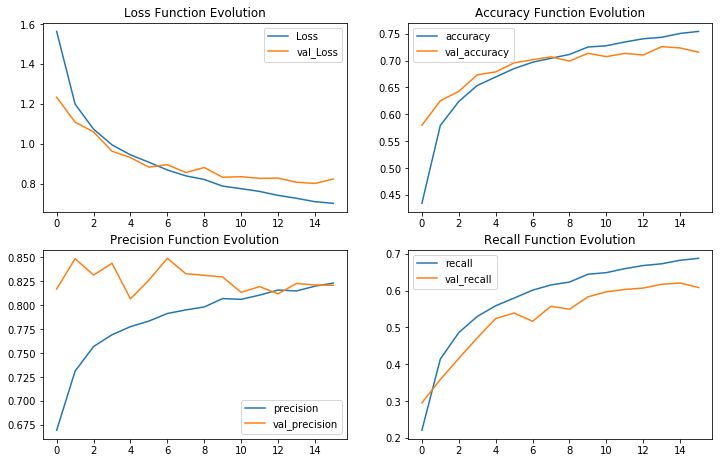

In [9]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

### Fast Gradient Signed Method (FGSM) attack to generate noise.

In [10]:
# Function to calculate adversary noise
def generate_adversary(image, label):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

Actual Predictions: automobile


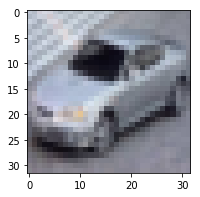

In [11]:
# Selecting random image for testing
rand_idx = randint(0,49999)
image = x_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Actual Predictions: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [12]:
# Adding the adversary noise to image
def pertubations(image,label):
    perturbations = generate_adversary(image,label).numpy()
    adversarial = image + (perturbations * 0.05)
    return adversarial

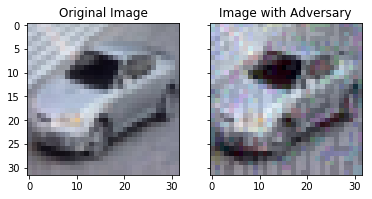

In [13]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
adversarial = pertubations(image,label)
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [14]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}. With confidence:- {100*np.max(model.predict(image)):2.0f}%')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}. With confidence:- {100*np.max(model.predict(adversarial)):2.0f}%")

Normal Image Prediction: automobile. With confidence:- 98%
Adversary Prediction: ship. With confidence:- 79%


In [15]:
#generating xtest_set with fgsm
i=0
xtest1 = np.zeros(shape=(len(x_test),32,32,3))
for x in x_test:
    x = x.reshape(1,height,width, channels)
    xtest1[i] = pertubations(x,y_test[i])
    i = i+1

In [18]:
result = model.evaluate(xtest1, y_test)
print("Test: loss = %f accuracy = %f  ;" % (result[0], result[1]))

10000/10000 [==============================] - 1s 135us/sample - loss: 7.5202 - accuracy: 0.0172 - precision: 0.0140 - recall: 0.0120
Test: loss = 7.520167 accuracy = 0.017200  ;
